In [1]:
from functools import partial
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, hstack
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
try:
  from google.colab import data_table
  from google.colab.data_table import DataTable
  data_table.enable_dataframe_formatter()
  DataTable.max_columns = 300
except ImportError:
  ...

pd.set_option('display.max_columns', None)

In [3]:
# Load csv into panda data frame

data_path = '/mnt/data/ml/learn/20240423_SonyL'

train_df = pd.read_csv('train_split.csv')
test_df = pd.read_csv('test_split.csv')
train_df.describe(include='all')


,case_id,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,target
count,1.221327e+06,1.221327e+06,1.221327e+06,886444.000000,7.722400e+05,1.221327e+06,1.221323e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,730480.000000,462759.000000,443134.000000,847287.000000,721138.000000,130023.00000,615583.000000,5.481250e+05,399716.000000,333598,153327,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,330.000000,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,856841.000000,852300.000000,946358.0,1.221327e+06,1221327,1.221323e+06,1.221323e+06,858922.000000,1221327.0,1.221327e+06,1220655,1.221327e+06,1.068670e+06,62413,30306,1.221327e+06,153826.000000,1221327,1.068670e+06,16663.0,1221327,9848,153826,1221327,867260.000000,1221327,23664.000000,2428.000000,2445.000000,1221327,1221327,606153.000000,1221327,1221327,977033,811968.000000,976333.0,976333.0,9.763330e+05,60966.000000,452601.000000,656652.000000,520149.000000,9.763330e+05,946358.000000,557611.000000,976333.000000,976333.000000,976333.000000,976333.000000,976333.000000,976333.000000,7.211380e+05,395071.000000,6.075230e+05,317972.000000,730480.000000,443134.000000,1.221327e+06,858923.000000,1.221327e+06,1.221327e+06,1.221327e+06,1.221327e+06,856935.000000,864393.000000,1.221323e+06,864393.000000,855824.000000,772240.000000,855824.000000,543587.000000,543587.000000,863363.000000,548805.000000,858923.000000,548805.000000,543587.000000,858923.000000,548805.000000,685762.000000,858923.000000,856535.000000,548805.000000,858922.000000,548805.000000,858922.000000,548805.000000,1.221327e+06,1.221327e+06,1.221327e+06,977033,1174425,1174425,854019.000000,851908.000000,854019.000000,853161.000000,852958.000000,1.185431e+06,1.158408e+06,1.115672e+06,1.076256e+06,1.042812e+06,1.221327e+06,1.221327e+06,8.646820e+05,5.488050e+05,1.221324e+06,1.221323e+06,282072.000000,1221254,324070,1.260660e+05,1.108499e+06,1.108499e+06,1.108499e+06,1.108499e+06,1.108499e+06,1200391,1200391,1200391,1.108499e+06,29190.000000,29190.000000,29190.000000,29190.0,29190.000000,29190.000000,29190.000000,29190.0,29190.000000,29190.000000,29190.000000,29190.000000,29190.0,29190.000000,29190.000000,29190.000000,1.108499e+06,1200391,1200391,1.108499e+06,114713.000000,91958.000000,57652.000000,91958.000000,57652.000000,116934.000000,458140.000000,458140.000000,538623,42795,42796.000000,1.108499e+06,1.108499e+06,1.221327e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,2,2,NaN,NaN,3,NaN,NaN,2,2,1,44,NaN,74,NaN,NaN,NaN,45,170,NaN,18,14,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
# Explore the data
train_df.sample(n=1000)

,case_id,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,f_80,f_81,f_82,f_83,f_84,f_85,f_86,f_87,f_88,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,f_100,f_101,f_102,f_103,f_104,f_105,f_106,f_107,f_108,f_109,f_110,f_111,f_112,f_113,f_114,f_115,f_116,f_117,f_118,f_119,f_120,f_121,f_122,f_123,f_124,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,f_134,f_135,f_136,f_137,f_138,f_139,f_140,f_141,f_142,f_143,f_144,f_145,f_146,f_147,f_148,f_149,f_150,f_151,f_152,f_153,f_154,f_155,f_156,f_157,f_158,f_159,f_160,f_161,f_162,f_163,f_164,f_165,f_166,f_167,f_168,f_169,f_170,f_171,f_172,f_173,f_174,f_175,f_176,f_177,f_178,f_179,f_180,f_181,f_182,f_183,f_184,f_185,f_186,f_187,f_188,f_189,f_190,f_191,f_192,f_193,f_194,f_195,target
200274,200274,202003,63,0.0,134444.780,5928.4,8370.601,0.0,0.0,0.0,0.0,0.0,1.0,-9.0,-1.0,-9.0,0.0,12222.2,79696.0,0.0,92043.400,8370.601,CA,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,0.0,80000.0,CAL,75243.400,0.0,0.0,0.0,80000.0,GBA,0.0,0.4500,NaN,NaN,0.0,NaN,CASH,0.4500,NaN,False,NaN,NaN,a55475b1,69000.0,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,a55475b1,a55475b1,A,60000.0,0.0,0.0,203440.0,NaN,0.0,0.0,0.0,93126.664,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,89009.4000,82416.0,100443.400,8370.601,-20.0,-20.0,2.0,16.0,1.0,0.0,0.0,0.0,23.0,14.0,12.0,21.0,0.0,0.0,23.0,15.0,21.0,11.0,11.0,0.0,0.0,10.0,10.0,10.0,3.0,3.0,21.0,21.0,9.0,9.0,9.0,9.0,0.0,0.0,0.0,False,OTHER,OTHER,0.52381,0.15000,0.14286,0.15000,0.15000,24.0,0.0,0.0,0.0,NaN,0.0,1.0,75243.400,75243.4,75243.400,142137.40,16741.201,FO,AL,NaN,1.0,1.0,0.0,1.0,0.0,a55475b1,a55475b1,a55475b1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,a55475b1,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEDUCTION_6,NaN,NaN,0.0,1.0,0
1194923,1194923,202001,55,0.0,0.000,3506.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,3614.0,NaN,3614.0,3614.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50998.0,COL,0.000,0.0,4060.0,0.0,50998.0,SBA,0.0,0.0000,NaN,NaN,1.0,NaN,POS,0.0000,NaN,False,NaN,NaN,P52_56_90,6915.6,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,9660.0,a55475b1,a55475b1,K,8000.0,0.0,0.0,9900.0,NaN,NaN,NaN,NaN,6915.600,3654.0,1.0,0.0,3654.0,0.0,0.0,0.0,3654.0,NaN,NaN,NaN,NaN,3573.0,3573.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,OTHER,OTHER,0.00000,1.00000,1.00000,1.00000,1.00000,18.0,0.0,0.0,0.0,50998.0,0.0,0.0,0.000,0.0,0.000,9900.00,NaN,FO,NaN,NaN,1.0,1.0,1.0,2.0,1.0,a55475b1,6b2ae0fa,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a7fcb6e5,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEDUCTION_6,NaN,NaN,0.0,1.0,0
347762,347762,201904,16,NaN,NaN,2216.6,0.000,0.0,0.0,0.0,8.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,26598.0,COL,0.000,0.0,NaN,0.0,26598.0,SBA,0.0,0.0000,NaN,NaN,0.0,NaN,POS,0.0000,NaN,False,NaN,NaN,a55475b1,NaN,a55475b1,NaN,NaN,NaN,a55475b1,a55475b1,NaN,a55475b1,a55475b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,OTHER,OTHER,NaN,NaN,NaN,NaN,NaN,12.0,0.0,0.0,0.0,26598.0,0.0,0.0,NaN,NaN,0.000,0.00,NaN,FO,NaN,NaN,2.0,2.0,1.0,2.0,2.0,a55475b1,a55475b1,a55475b1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,a55475b1,a55475b1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,101398.330,NaN,NaN,NaN,1.0,0.0,0
715097,715097,201912,50,0

In [5]:
# split the input and output columns
def split_input_output(df):
  input = df.drop(columns=['case_id', 'target'])
  output = df[['target']]
  return input, output

train_input, train_output = split_input_output(train_df)
test_input, test_output = split_input_output(test_df)



In [6]:
# Explore data
def compute_data_summary():
  data_info = pd.DataFrame()
  data_info['dtype'] = train_input.dtypes
  data_info['nunique'] = train_input.apply(pd.Series.nunique)
  data_info['min'] = train_input.apply(lambda s: 0.0 if s.dtype == bool else 0 if s.dtype == object else s.min())
  data_info['max'] = train_input.apply(lambda s: 1.0 if s.dtype == bool else 0 if s.dtype == object else s.max())
  data_info['%na'] = train_input.apply(lambda s: (1 - s.count() / len(s)) * 100.0)
  def _top_values(series, n=8):
    return ' '.join(series.value_counts().iloc[:n].to_frame(0).apply(
        lambda row: f'{row.name}:{row[0]}', axis=1).to_list())
  data_info['top_values'] = train_input.apply(_top_values)
  return data_info

data_summary = compute_data_summary()
data_summary


,dtype,nunique,min,max,%na,top_values
f_1,int64,22,201901.000000,2.020100e+05,0.000000,201912:100794 201911:92626 201909:79192 201908...
f_2,int64,92,0.000000,9.100000e+01,0.000000,51:28869 47:25357 49:24714 45:23165 23:21375 5...
f_3,float64,155,0.000000,4.206000e+03,27.419602,0.0:883354 1.0:1060 2.0:587 3.0:387 4.0:189 5....
f_4,float64,506576,0.000000,1.408010e+06,36.770414,0.0:128832 800.0:73 4000.0:66 6000.0:63 13998....
f_5,float64,71867,80.800000,1.060070e+05,0.000000,6000.0:9317 600.0:3492 2000.0:1951 1200.0:1663...
...,...,...,...,...,...,...
f_191,object,3,0.000000,0.000000e+00,55.898543,DEDUCTION_6:440345 PENSION_6:93629 SOCIAL_6:4649
f_192,object,16,0.000000,0.000000e+00,96.496024,3% - 4%:5158 2% - 3%:4886 4% - 6%:4490 2% - 2%...
f_193,float64,201,-3.670423,2.119132e+00,96.495943,0.0:2902 1.2063642:664 0.8673362:647 1.2846014...
f_194,float64,53,0.000000,1.090000e+02,9.238148,0.0:317194 1.0:208091 2.0:161770 3.0:114923 4....


In [7]:
# Show distribution for each column in train_df 

# for col in train_input:
#   if train_input[col].dtype in (object, bool):
#     train_input[col].value_counts()[:100].plot(kind='bar')
#   else:
#     plt.hist(train_df[col], bins=100)
#   plt.title(f"Distribution of {col}")
#   plt.show()


In [8]:
# preprocessing function to help handle missing values, normalization, and encoding
def preprocess(df, info=None):
  if info is None:
    info = {}

  df_copy = df.copy()

  categorical_columns_selector = (
      (data_summary['dtype'] == object) |
      (data_summary['dtype'] == bool)
      # | (data_summary['dtype'] == np.int64)
      # | (data_summary['nunique'] <= 20)
  )
  categorical_columns = data_summary[categorical_columns_selector].index.to_list()

  def _normalize_year_month(year_month):
    year = year_month // 100
    month = year_month % 100
    return (year - 2019) * 12 + month - 1
  df_copy['f_1'] = df_copy['f_1'].apply(_normalize_year_month)

  def _log(x, eps=0.1):
    return np.copysign(np.log(np.abs(x) + eps) - np.log(eps), x)

  large_numerical_columns_selector = (
      ~categorical_columns_selector &
      (data_summary.index != 'f_1') &
      ((data_summary['max'] - data_summary['min']) > 1000)
  )
  large_numerical_columns = data_summary[large_numerical_columns_selector].index.to_list()
  df_copy[large_numerical_columns] = df_copy[large_numerical_columns].apply(_log)

  df_categorical = df_copy[categorical_columns]
  df_copy.drop(columns=categorical_columns, inplace=True)
  df_numerical = df_copy

  for col in df_numerical:
    # Cast everything to float32.
    df_numerical[col] = df_numerical[col].astype(np.float32)

  if 'one_hot_enc' not in info:
    # Has to be sparse otherwise OOM.
    one_hot_enc = OneHotEncoder(drop='if_binary',
                                sparse_output=True,
                                handle_unknown='ignore',
                                dtype=np.float32)
    one_hot_enc.fit(df_categorical)
    info['one_hot_enc'] = one_hot_enc
  one_hot_encoded = info['one_hot_enc'].transform(df_categorical)

  if 'scaler' not in info:
    scaler = StandardScaler()
    scaler.fit(df_numerical)
    info['scaler'] = scaler
  df_numerical = info['scaler'].transform(df_numerical)

  if 'imp' not in info:
    imp = SimpleImputer()
    imp.fit(df_numerical)
    info['imp'] = imp
  df_numerical = info['imp'].transform(df_numerical)

  concatenated = hstack([df_numerical, one_hot_encoded], format="csr")
  return concatenated, info

train_processed, preprocess_info = preprocess(train_input)
test_processed, _ = preprocess(test_input, preprocess_info)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2, 6, 10, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
(train_input_train, train_input_validation,
 train_output_train, train_output_validation) = train_test_split(
     train_processed, train_output, test_size=0.2, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Eval of validation set
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    236641
           1       0.08      0.71      0.14      7625

    accuracy                           0.73    244266
   macro avg       0.53      0.72      0.49    244266
weighted avg       0.96      0.73      0.82    244266

AUC Score: 0.7938260239398395


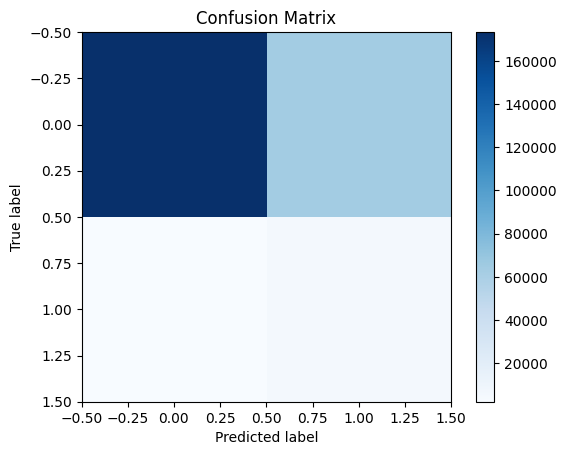

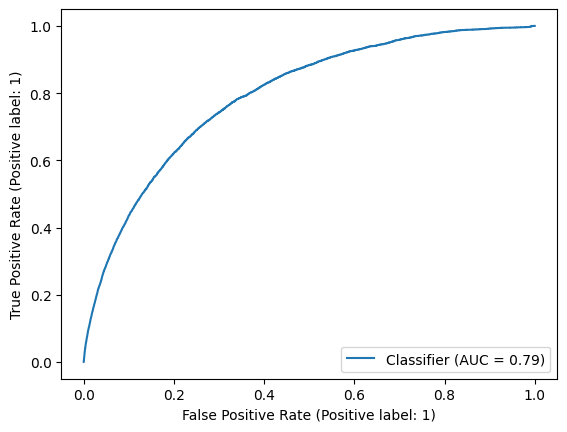

In [10]:
# Test #1 (not used)
# initialze and train adaboostclassifier
rf_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=100,
    random_state=0,
)
rf_clf.fit(train_input_train, train_output_train)

# Evaluate the model
print('Eval of validation set')
rf_val_pred = rf_clf.predict(train_input_validation)
print(classification_report(train_output_validation, rf_val_pred))
rf_val_prob = rf_clf.predict_proba(train_input_validation)
print(f'AUC Score: {roc_auc_score(train_output_validation, rf_val_prob[:, 1])}')

# Plot the confusion matrix
rf_cm = confusion_matrix(train_output_validation, rf_val_pred)
plt.imshow(rf_cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# display the curve
RocCurveDisplay.from_predictions(train_output_validation, rf_val_prob[:, 1])
plt.show()

# generate predictions
rf_test_prob = pd.DataFrame({"target": rf_clf.predict_proba(test_processed)[:, 1]})
rf_test_prob.to_csv(f'{data_path}/rf_test_prob.csv', index=False)




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Eval of validation set
              precision    recall  f1-score   support

           0       0.99      0.68      0.80    236641
           1       0.07      0.72      0.12      7625

    accuracy                           0.68    244266
   macro avg       0.53      0.70      0.46    244266
weighted avg       0.96      0.68      0.78    244266

AUC Score: 0.7670711724150735


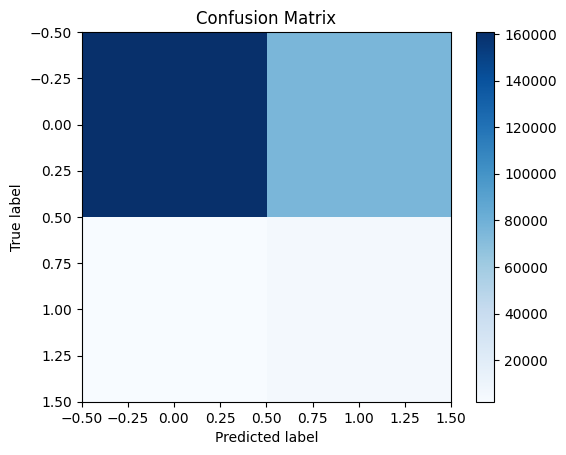

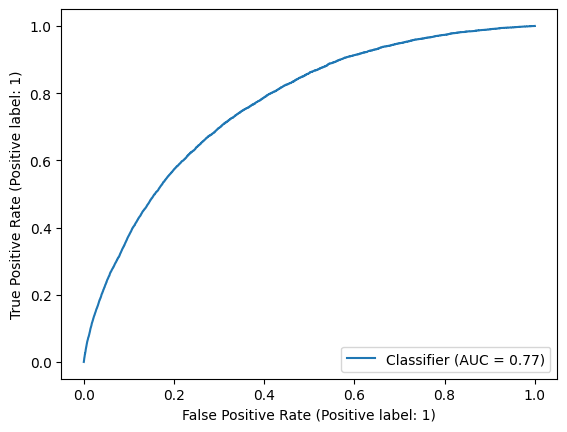

In [11]:
# Test 2 (not used)
svm_clf = LinearSVC(loss='hinge', class_weight='balanced', verbose=2)
svm_clf.fit(train_input_train, train_output_train)

# Evaluate the model
print('Eval of validation set')
svm_val_pred = svm_clf.predict(train_input_validation)
print(classification_report(train_output_validation, svm_val_pred))
svm_val_prob = svm_clf.decision_function(train_input_validation)
print(f'AUC Score: {roc_auc_score(train_output_validation, svm_val_prob)}')

# Plot the confusion matrix
svm_cm = confusion_matrix(train_output_validation, svm_val_pred)
plt.imshow(svm_cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# display roc curve
RocCurveDisplay.from_predictions(train_output_validation, svm_val_prob)
plt.show()

svm_test_prob = pd.DataFrame({"target": svm_clf.decision_function(test_processed)})
svm_test_prob.to_csv(f'{data_path}/svm_test_prob.csv', index=False)


In [10]:
# Adjust weights for pos and neg samples.
neg_count, pos_count = np.bincount(train_output.to_numpy().flatten())
total_count = neg_count + pos_count

weight_for_0 = (1 / neg_count) * (total_count / 2.0)
weight_for_1 = (1 / pos_count) * (total_count / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 15.90


In [13]:
# Building the multi layer perception in sklearn with cross entropy loss

# Build the model
# model = MLPClassifier(hidden_layer_sizes=(100, 50),
#                       activation='relu',
#                       solver='adam',
#                       max_iter=1000,
#                       early_stopping=True,
#                       validation_fraction=0.1,
#                       verbose=True)
# model.fit(train_input_train, train_output_train)

# # Evaluate the model
# y_pred = model.predict(train_input_validation)
# print(classification_report(train_output_validation, y_pred))

# # Plot the confusion matrix
# cm = confusion_matrix(train_output_validation, y_pred)
# plt.imshow(cm, cmap='Blues')
# plt.colorbar()
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - Brier score: 0.2336 - accuracy: 0.6468 - auc: 0.6369 - cross entropy: 0.6677 - fn: 6607.3501 - fp: 157486.5000 - loss: 0.6710 - prc: 0.0610 - precision: 0.0492 - recall: 0.5492 - tn: 320574.1562 - tp: 8867.2412 - val_Brier score: 0.2153 - val_accuracy: 0.6498 - val_auc: 0.7809 - val_cross entropy: 0.6186 - val_fn: 1781.0000 - val_fp: 83759.0000 - val_loss: 0.6186 - val_prc: 0.1194 - val_precision: 0.0656 - val_recall: 0.7676 - val_tn: 152845.0000 - val_tp: 5881.0000
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - Brier score: 0.2031 - accuracy: 0.6686 - auc: 0.7569 - cross entropy: 0.5913 - fn: 4288.0332 - fp: 158635.0938 - loss: 0.5934 - prc: 0.0965 - precision: 0.0660 - recall: 0.7224 - tn: 319362.9062 - tp: 11249.2168 - val_Brier score: 0.1915 - val_accuracy: 0.6889 - val_auc: 0.7888 - val_cross entropy: 0.5586 - val_fn: 1979.0000 - val_fp: 74009.0000 - val_loss: 0.5586 - val_prc: 0.1278 - val_precision: 0.0713 - va

239/239 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - Brier score: 0.1895 - accuracy: 0.6994 - auc: 0.7978 - cross entropy: 0.5522 - fn: 3717.4624 - fp: 145079.9531 - loss: 0.5473 - prc: 0.1204 - precision: 0.0752 - recall: 0.7588 - tn: 332987.0625 - tp: 11750.7793 - val_Brier score: 0.1833 - val_accuracy: 0.7208 - val_auc: 0.8036 - val_cross entropy: 0.5359 - val_fn: 2055.0000 - val_fp: 66134.0000 - val_loss: 0.5359 - val_prc: 0.1453 - val_precision: 0.0782 - val_recall: 0.7318 - val_tn: 170470.0000 - val_tp: 5607.0000
Epoch 16/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - Brier score: 0.1894 - accuracy: 0.7007 - auc: 0.7965 - cross entropy: 0.5521 - fn: 3723.9167 - fp: 144580.9062 - loss: 0.5482 - prc: 0.1205 - precision: 0.0754 - recall: 0.7578 - tn: 333483.5312 - tp: 11746.8877 - val_Brier score: 0.1914 - val_accuracy: 0.7033 - val_auc: 0.8043 - val_cross entropy: 0.5550 - val_fn: 1882.0000 - val_fp: 70592.0000 - val_loss: 0.5550 - val_prc: 0.1444 - val_precision: 0.0757 - val_recall: 

239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - Brier score: 0.1886 - accuracy: 0.6934 - auc: 0.8060 - cross entropy: 0.5449 - fn: 3491.6499 - fp: 147404.3594 - loss: 0.5373 - prc: 0.1277 - precision: 0.0754 - recall: 0.7740 - tn: 330576.7812 - tp: 12062.4414 - val_Brier score: 0.1817 - val_accuracy: 0.7180 - val_auc: 0.8034 - val_cross entropy: 0.5268 - val_fn: 1982.0000 - val_fp: 66908.0000 - val_loss: 0.5268 - val_prc: 0.1459 - val_precision: 0.0782 - val_recall: 0.7413 - val_tn: 169696.0000 - val_tp: 5680.0000
Epoch 30/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - Brier score: 0.1866 - accuracy: 0.6983 - auc: 0.8092 - cross entropy: 0.5401 - fn: 3429.9583 - fp: 145546.4844 - loss: 0.5328 - prc: 0.1301 - precision: 0.0765 - recall: 0.7778 - tn: 332496.4062 - tp: 12062.3955 - val_Brier score: 0.1870 - val_accuracy: 0.7068 - val_auc: 0.8040 - val_cross entropy: 0.5421 - val_fn: 1897.0000 - val_fp: 69721.0000 - val_loss: 0.5421 - val_prc: 0.1452 - val_precision: 0.0764 - val_recall: 

239/239 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - Brier score: 0.1855 - accuracy: 0.6981 - auc: 0.8158 - cross entropy: 0.5349 - fn: 3289.1667 - fp: 146408.2812 - loss: 0.5253 - prc: 0.1322 - precision: 0.0777 - recall: 0.7881 - tn: 331561.8750 - tp: 12275.9209 - val_Brier score: 0.1871 - val_accuracy: 0.6930 - val_auc: 0.8026 - val_cross entropy: 0.5360 - val_fn: 1801.0000 - val_fp: 73196.0000 - val_loss: 0.5360 - val_prc: 0.1461 - val_precision: 0.0741 - val_recall: 0.7649 - val_tn: 163408.0000 - val_tp: 5861.0000
Epoch 44/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - Brier score: 0.1880 - accuracy: 0.6891 - auc: 0.8146 - cross entropy: 0.5403 - fn: 3201.7209 - fp: 148964.8125 - loss: 0.5290 - prc: 0.1327 - precision: 0.0769 - recall: 0.7958 - tn: 328965.7812 - tp: 12402.9463 - val_Brier score: 0.1881 - val_accuracy: 0.7023 - val_auc: 0.8030 - val_cross entropy: 0.5428 - val_fn: 1876.0000 - val_fp: 70854.0000 - val_loss: 0.5428 - val_prc: 0.1450 - val_precision: 0.0755 - val_recall: 

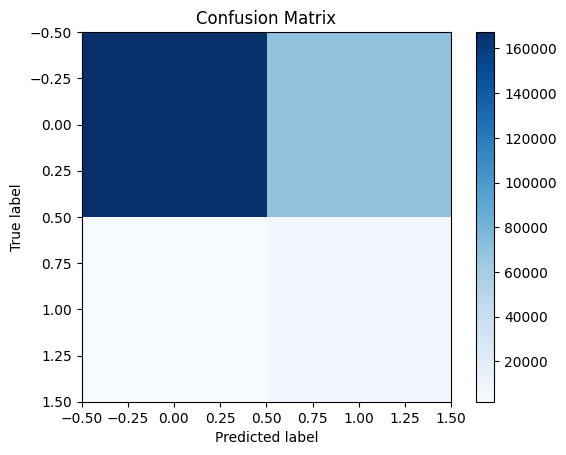

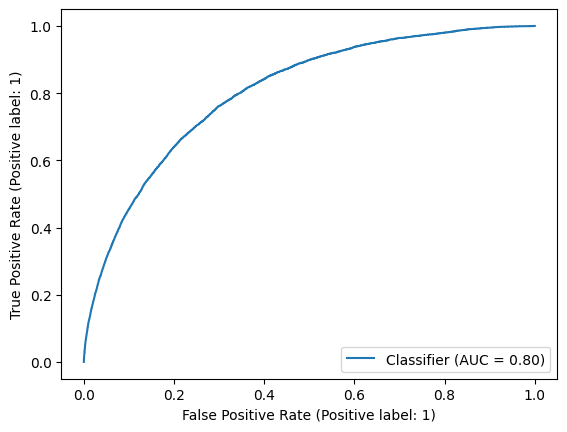

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 6s 655us/step


In [11]:
# Define the model
model = Sequential([
    layers.Dense(100, activation='relu', input_shape=[train_input_train.shape[1]]),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(25, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

# Define metrics
metrics = [
    metrics.BinaryCrossentropy(name='cross entropy'),  
    metrics.MeanSquaredError(name='Brier score'),
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'),
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR'), 
]

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# Define callbacks for stopping and model checkpoints
checkpoint_filepath = 'checkpoint.weights.h5'  # specified directory
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=20,
        restore_best_weights=True),
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_auc',
        mode='max',
        save_best_only=True),
]

# for training the model
history = model.fit(train_input_train,
                    train_output_train.to_numpy(),
                    epochs=100,
                    batch_size=4096,
                    callbacks=callbacks,
                    validation_data=(train_input_validation, train_output_validation.to_numpy()),
                    class_weight=class_weight)

# Evaluate the model
print('Eval of validation set')
nn_val_prob = model.predict(train_input_validation)
nn_val_pred = nn_val_prob > 0.5
print(classification_report(train_output_validation, nn_val_pred))
print(f'AUC Score: {roc_auc_score(train_output_validation, nn_val_prob)}')

# Plot the confusion matrix
nn_cm = confusion_matrix(train_output_validation, nn_val_pred)
plt.imshow(nn_cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# display roc curve for neural network model
RocCurveDisplay.from_predictions(train_output_validation, nn_val_prob)
plt.show()

# Make predictions on test data
nn_test_prob = pd.DataFrame({"target": model.predict(test_processed)[:, 0]})
nn_test_prob.to_csv('nn_test_prob.csv', index=False)